<a href="https://colab.research.google.com/github/tgrappoport/2dmat/blob/master/4_topology_Haldane.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook uses Haldane model to illustrates a few consequences of having a topological material. You can learn about this model with Haldane, watching [his online lecture](https://topocondmat.org/w4_haldane/haldane_model.html).

The notebook is extense and we should avoid running all cells at once. If you still want to do that, take some time as the last part of the notebook has an time consuming calculation.

We begin by defining a class named Berry that calculates the Berry curvature in k-space using the *pybinding* output. It uses an efficient numerical method known as [Fukui´s method](https://journals.jps.jp/doi/pdf/10.1143/JPSJ.74.1674), described in a symplified way [here](https://www.openmx-square.org/openmx_man3.9/node226.html#FHS2005). The same class also contains a function to plot the Berry curvature and calculate the Chern number of the valence band.

We then define the Haldane model, show the lattice and hopping. With this in hand, we calculate the eigenfunctions and eigenvalues in the Brillouin zone. We use the data to calculate the Berry curvature and Chern numbers in two different topological phases.

We proceed by cuting our lattice in a ribbon to show that the band structure of the topological phase present edge states crossing the gap, consistent with the bulk-edge correspondance.

Finally, we use quantum-kite to perform transport calculations and show the quantized hall conductivity of the Haldane model.






In [1]:
%%capture --no-display
!pip install h5py==3.8.0
!pip install -i https://test.pypi.org/simple/ pybinding quantum-kite==0.0.3a
import numpy as np
import matplotlib.pyplot as plt
import pybinding as pb
from math import sqrt, pi
from pybinding.repository import graphene
import kite


The Fukui-Hatsugai-Suzuki method is a numerical approach to calculate the Berry connection and Berry curvature of a quantum system in a lattice model. It relies on the concept of the overlap matrix $\mathbf{U}$, which describes the overlap between different eigenstates of the Hamiltonian at neighboring $\mathbf{k}$ points in the Brillouin zone.


This method provides a numerical estimate of the Berry curvature and is particularly useful for systems where analytical expressions are not available.  It does not require a very fine grid as it uses the idea of calculating the Berry curvature of each plaquete in the Brillouin zone, as illustrated below:

<img src="https://raw.githubusercontent.com/tgrappoport/2dmat/master/fukui.001.jpeg?token=GHSAT0AAAAAACILH532RGAKAAU5TXEJVM5CZJADTPA" width="200" height="220">


Because of the topological properties, the Chern number needs to be well defined even if the grid has few plaquetes.


To calculate the Berry curvature at a specific $\mathbf{k}$ point, follow these steps:

1. Discretize the Brillouin zone: Choose a grid of $\mathbf{k}$ points in the Brillouin zone.

2. Calculate the eigenstates and eigenvalues: For each $\mathbf{k}$ point in the grid, obtain the eigenvectors $|u_n(\mathbf{k})\rangle$ and eigenvalues $E_n(\mathbf{k})$ of the Hamiltonian $H(\mathbf{k})$. For each plaquete, we have four different eigenstates

3. Compute the overlap matrix $\mathbf{U}$ between first neighbor points: The overlap matrix $\mathbf{U}$ is defined as:

$$
\mathbf{U}_{mn}(\mathbf{k}) = \langle u_m(\mathbf{k}) | u_n(\mathbf{k} + \Delta \mathbf{k}) \rangle
$$


Here, $m$ and $n$ label the eigenstates at the current $\mathbf{k}$ point and the neighboring $\mathbf{k}$ point $\mathbf{k} + \Delta \mathbf{k}$, respectively. $\Delta \mathbf{k}$ represents the distance between the neighboring points in the $\mathbf{k}$ space.



4. Compute the Berry curvature $\Omega(\mathbf{k})$  using the overlap matrix $\mathbf{U}_{mn}(\mathbf{k})$ as follows:

For each plaquete illustrated above, we compute the four overlap matrices and use

$$\Omega(\mathbf{k})=\Im\log(U_{12}U_{23}U_{34}U_{41})$$



5. Sum over all grid points in the BZ: Finally, sum up the contributions from all $\mathbf{k}$ points and devide by $2\pi$ to obtain the Chern number:
$$C=\frac{1}{2\pi}\sum_{k\in BZ}\Omega(\mathbf{k})$$



In [2]:
class Berry:
    def __init__(self,uLambda,lambSpace):
        self.uLambda = uLambda
        self.lambSpace = lambSpace
        self.lamStep_x = lambSpace.shape[0]
        self.lamStep_y = lambSpace.shape[1]
        self.h_x = np.array([np.gradient(lambSpace[:,i,0]) for i in range(self.lamStep_x)],dtype=np.complex128)
        self.h_y = np.array([np.gradient(lambSpace[i,:,1]) for i in range(self.lamStep_y)],dtype=np.complex128)




    def fukui_curvature(self):
        F_curv = np.empty([self.uLambda.shape[0],self.uLambda.shape[1]])
        for i in range(self.lamStep_x):
            for j in range(self.lamStep_y):
                if j == self.lamStep_y-1 and i!= self.lamStep_x-1 :
                    U12 = np.vdot(self.uLambda[i,j,:],self.uLambda[i,j-1,:])
                    U23 = np.vdot(self.uLambda[i,j-1,:],self.uLambda[i+1,j-1,:])
                    U34 = np.vdot(self.uLambda[i+1,j-1,:],self.uLambda[i+1,j,:])
                    U41 = np.vdot(self.uLambda[i+1,j,:],self.uLambda[i,j,:])
                elif j != self.lamStep_y-1 and i == self.lamStep_x-1 :
                    U12 = np.vdot(self.uLambda[i,j,:],self.uLambda[i,j+1,:])
                    U23 = np.vdot(self.uLambda[i,j+1,:],self.uLambda[i-1,j+1,:])
                    U34 = np.vdot(self.uLambda[i-1,j+1,:],self.uLambda[i-1,j,:])
                    U41 = np.vdot(self.uLambda[i-1,j,:],self.uLambda[i,j,:])
                elif j == self.lamStep_y-1 and i == self.lamStep_x-1 :
                    U12 = np.vdot(self.uLambda[i,j,:],self.uLambda[i-1,j,:])
                    U23 = np.vdot(self.uLambda[i-1,j,:],self.uLambda[i-1,j-1,:])
                    U34 = np.vdot(self.uLambda[i-1,j-1,:],self.uLambda[i,j-1,:])
                    U41 = np.vdot(self.uLambda[i,j-1,:],self.uLambda[i,j,:])
                else:
                    U12 = np.vdot(self.uLambda[i,j,:],self.uLambda[i+1,j,:])
                    U23 = np.vdot(self.uLambda[i+1,j,:],self.uLambda[i+1,j+1,:])
                    U34 = np.vdot(self.uLambda[i+1,j+1,:],self.uLambda[i,j+1,:])
                    U41 = np.vdot(self.uLambda[i,j+1,:],self.uLambda[i,j,:])
                F_curv[i,j] = np.imag(np.log(U12*U23*U34*U41))

        return F_curv


    def chern(self):
        berrCurv = self.fukui_curvature()
        Chern = 0
        for i in range(berrCurv.shape[0]):
            for j in range(berrCurv.shape[1]):
                 #again, assuming an homogeneous step, therefore, each volume fraction of the domain dS is the same.
                Chern += berrCurv[i,j] /2/pi

        return Chern

    def curv_plot(self):
        krange = self.lambSpace.reshape([self.lamStep_x*self.lamStep_y,2])
        berrCurv = self.fukui_curvature()

        grid_x, grid_y = np.mgrid[krange[0,0]:krange[-1,0]:100j, krange[0,-1]:krange[-1,-1]:100j]
        plt.figure(figsize=(6,5))
        grid_z0 = griddata(krange, berrCurv.reshape(berrCurv.shape[0]*berrCurv.shape[1]), (grid_x, grid_y), method='cubic')
        image=plt.imshow(grid_z0.T, extent=(krange[0,0],krange[-1,0],krange[0,-1],krange[-1,-1]), origin='lower')
        plt.colorbar().set_label('$\Omega(\mathbf{k})$')
        plt.xlabel('$k_{x}$')
        plt.ylabel('$k_{y}$')



Let us now define the Hamiltonian (lattice in *pybinding*´s nomenclature)

In [3]:


def haldane(onsite=0, t=1, t2=0.05):
    """Return lattice specification for Haldane model"""

    # parameters

    a_cc = 1  # [nm] carbon-carbon distance
    a = a_cc*sqrt(3) # [nm] unit cell length


    # define lattice vectors
    a1 = a * np.array([1, 0])
    a2 = a * np.array([1 / 2, 1 / 2 * np.sqrt(3)])

    # create a lattice with 2 primitive vectors
    lat = pb.Lattice(a1=a1, a2=a2)

    # add sublattices
    lat.add_sublattices(
        # name, position, and onsite potential
        ('A', [0, -a_cc/2], -onsite),
        ('B', [0,  a_cc/2], +onsite)
    )

    # Add hoppings
    lat.add_hoppings(
        # inside the main cell, between which atoms, and the value
        ([0, 0], 'A', 'B', -t),
        # between neighboring cells, between which atoms, and the value
        ([1, -1], 'A', 'B', -t),
        ([0, -1], 'A', 'B', -t),
        ([1, 0], 'A', 'A', -t2 * 1j),
        ([0, -1], 'A', 'A', -t2 * 1j),
        ([-1, 1], 'A', 'A', -t2 * 1j),
        ([1, 0], 'B', 'B', -t2 * -1j),
        ([0, -1], 'B', 'B', -t2 * -1j),
        ([-1, 1], 'B', 'B', -t2 * -1j)
    )
    return lat



We can now check the lattice and its main characteristics by using pybinding features. In the first case, we set M to be zero and in the second case, finite. We can see that if the onsite staggered potential is finite, the gaps in K and K´ are different. Eventually the gap closes and there is a topological phase transition from a topological to a trivial state.

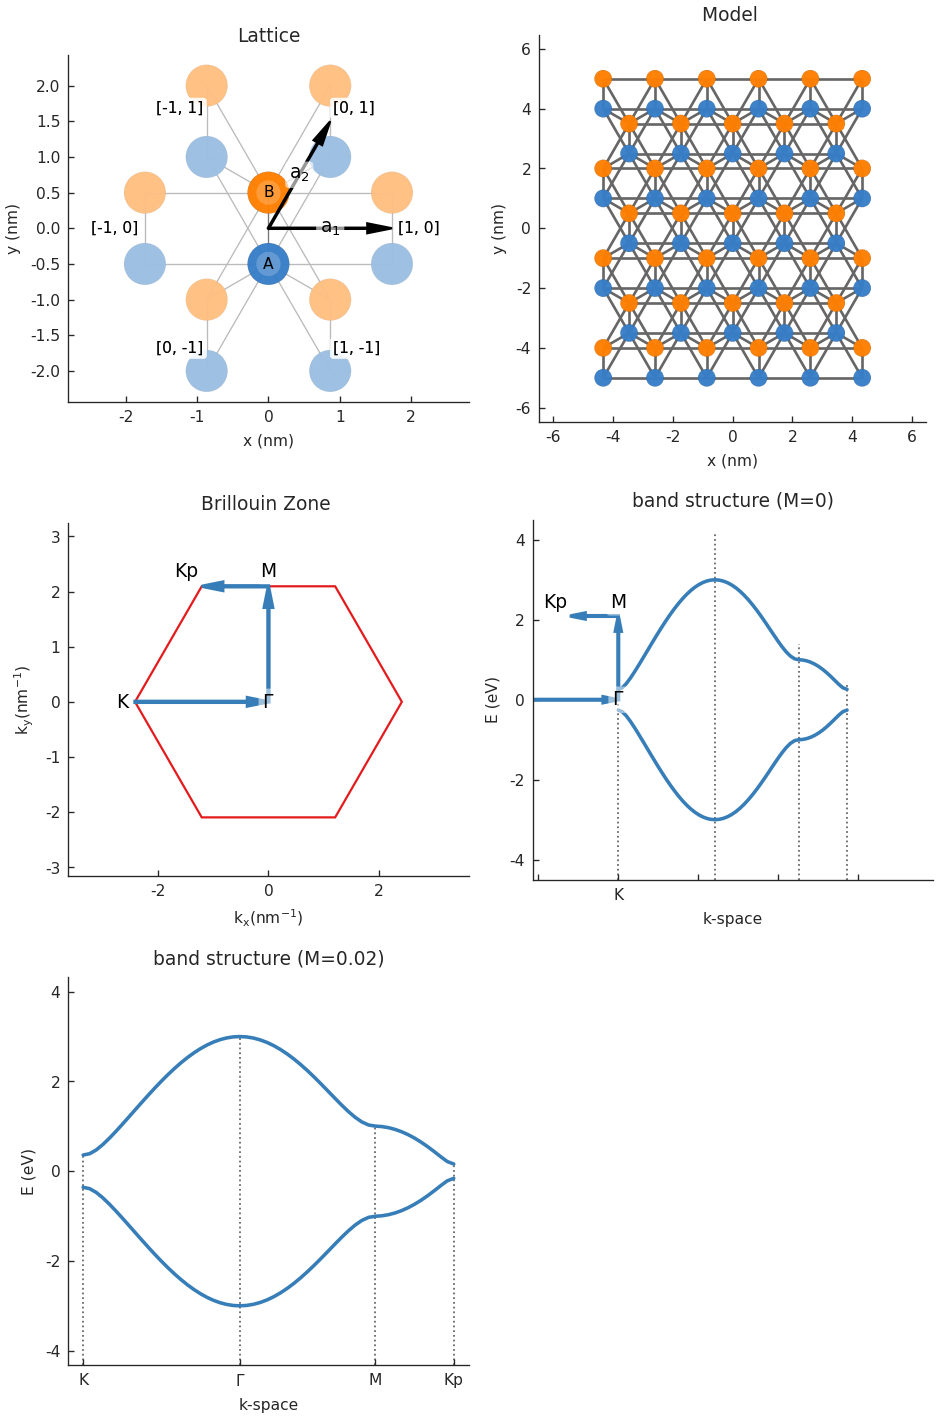

In [4]:
pb.pltutils.use_style()
lattice = haldane()
plot=plt.figure(figsize=(6., 9.))
plt.subplot(321, title="Lattice")
lattice.plot()
model = pb.Model(haldane(), pb.rectangle(10))
plt.subplot(322, title="Model ")
model.plot(hopping={'width': 2, 'cmap': 'auto'})
#model.plot()
plt.subplot(323, title="Brillouin Zone ")
lattice.plot_brillouin_zone(decorate=False)
k_points = model.lattice.brillouin_zone()
a_cc = 1
Gamma = [0, 0]
K1 = [-4*pi / (3*sqrt(3)*a_cc), 0]
M = [0, 2*pi / (3*a_cc)]
K2 = [-2*pi / (3*sqrt(3)*a_cc), 2*pi / (3*a_cc)]
model = pb.Model(haldane(), pb.translational_symmetry())
solver = pb.solver.lapack(model)
bands = solver.calc_bands(K1, Gamma, M, K2)
bands.plot_kpath(point_labels=['K', r'$\Gamma$', 'M', 'Kp'])

plt.subplot(324, title="band structure (M=0)")
bands.plot(point_labels=['K', r'$\Gamma$', 'M', 'Kp'])
model = pb.Model(haldane(onsite=0.1), pb.translational_symmetry())
solver = pb.solver.lapack(model)
bands = solver.calc_bands(K1, Gamma, M, K2)
bands.plot_kpath(point_labels=['K', r'$\Gamma$', 'M', 'Kp'])

plt.subplot(325, title="band structure (M=0.02)")
bands.plot(point_labels=['K', r'$\Gamma$', 'M', 'Kp'])
plt.tight_layout()
plt.show(plot)


Now we can calculate the Berry curvature and Chern numbers for the two different phases. For simplicity, we define a rectangular Brillouin zone. For the topological phase where the onsite staggered potential is zero, we plot the valence and conduction band in the BZ and the Berry curvature, which has peaks in K and K´.

The Chern number of the band is: -1.021752202431981


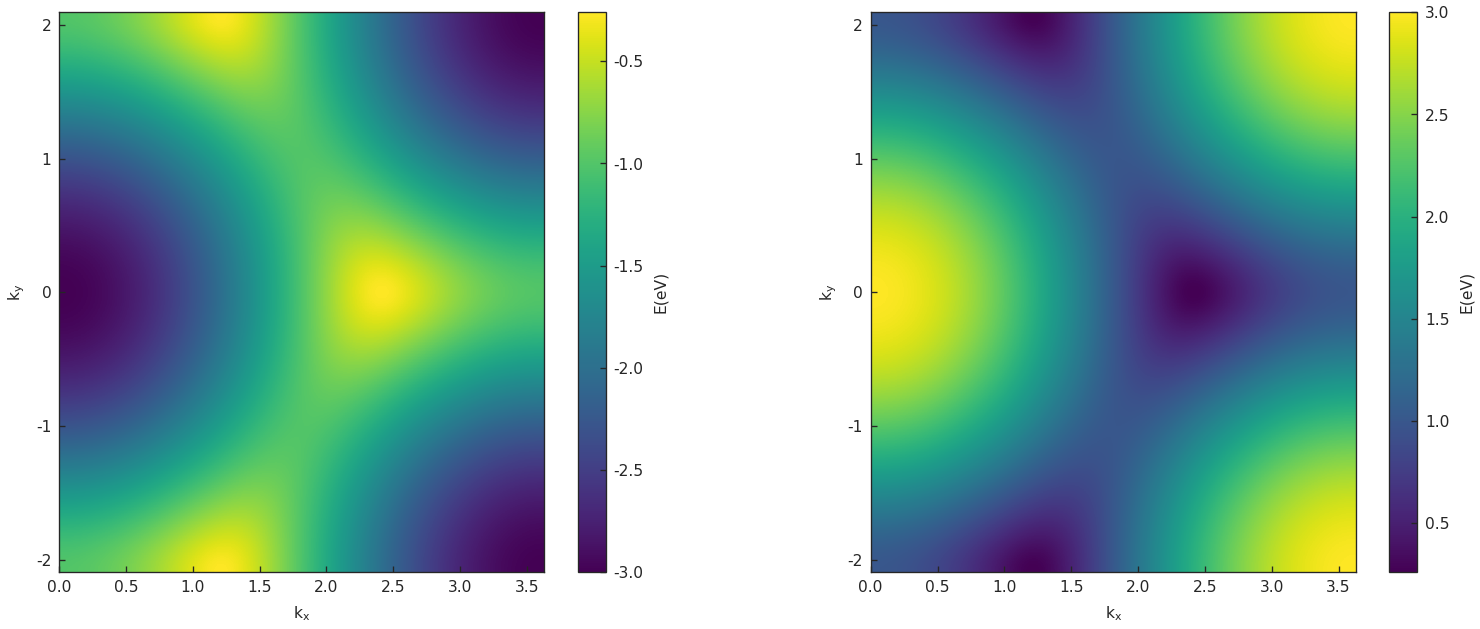

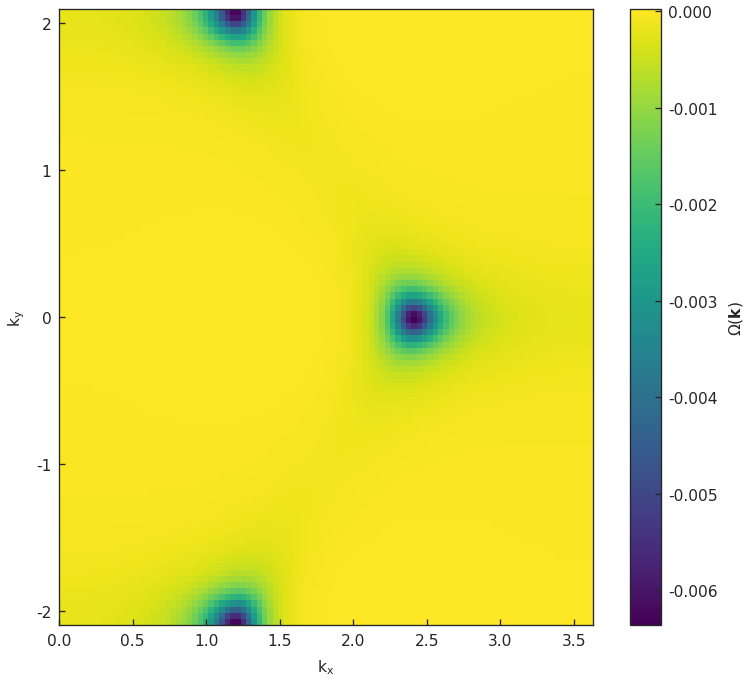

In [5]:
model = pb.Model(
    haldane(),
    pb.translational_symmetry()
)

kstep = 200
solver = pb.solver.lapack(model)
# krange = [[kx,ky] for kx in np.linspace(2.5*pi/a,3.5*pi/a,kstep) for ky in np.linspace(3.5*pi/a,4.5*pi/a,kstep)]
krange = [[kx,ky] for kx in np.linspace(0,6*pi/(3*sqrt(3)),kstep) for ky in np.linspace(-2*pi/3,2*pi/3,kstep)]
bands = np.empty([len(krange),2])
eigvects = np.empty([len(krange),2,2],dtype=np.complex128)
for i in range(len(krange)):
    solver.set_wave_vector(krange[i])
    bands[i,:] = solver.eigenvalues
    eigvects[i,:,:] = solver.eigenvectors

krange = np.array(krange)
#eigvects = fixedGauge(eigvects)
from scipy.interpolate import griddata
grid_x, grid_y = np.mgrid[krange[0,0]:krange[-1,0]:200j, krange[0,-1]:krange[-1,-1]:200j]

plt.figure(figsize=(12,10))
# plt.title('Energy eigenvalues')
for i in range(bands.shape[1]):
    plt.subplot(2,2,i+1)
    grid_z0 = griddata(krange, bands[:,i], (grid_x, grid_y), method='cubic')
    plt.imshow(grid_z0.T, extent=(krange[0,0],krange[-1,0],krange[0,-1],krange[-1,-1]), origin='lower')
    plt.colorbar().set_label('E(eV)')
    plt.xlabel('$k_{x}$')
    plt.ylabel('$k_{y}$')

krangefun = krange.reshape(kstep,kstep,2)
eigvectsfun = eigvects[:,:,1].reshape(kstep,kstep,2) #Just studying the eigenvectors of one the bands

BerryHaldane = Berry(eigvectsfun,krangefun)

ChernNumber = BerryHaldane.chern()
print(f"The Chern number of the band is: {ChernNumber}")
berrCurv_fukui = BerryHaldane.fukui_curvature()
#print(berrCurv_fukui)
BerryHaldane.curv_plot()


For the case where the system is not topological, the band structure shows differences in K and K´. Moreover, the Berry curvature has positive and negative values and its integral is zero (within numerical error)

The Chern number of the band is: -0.00590719002992523


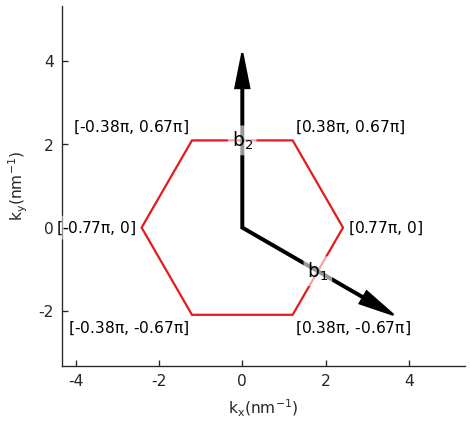

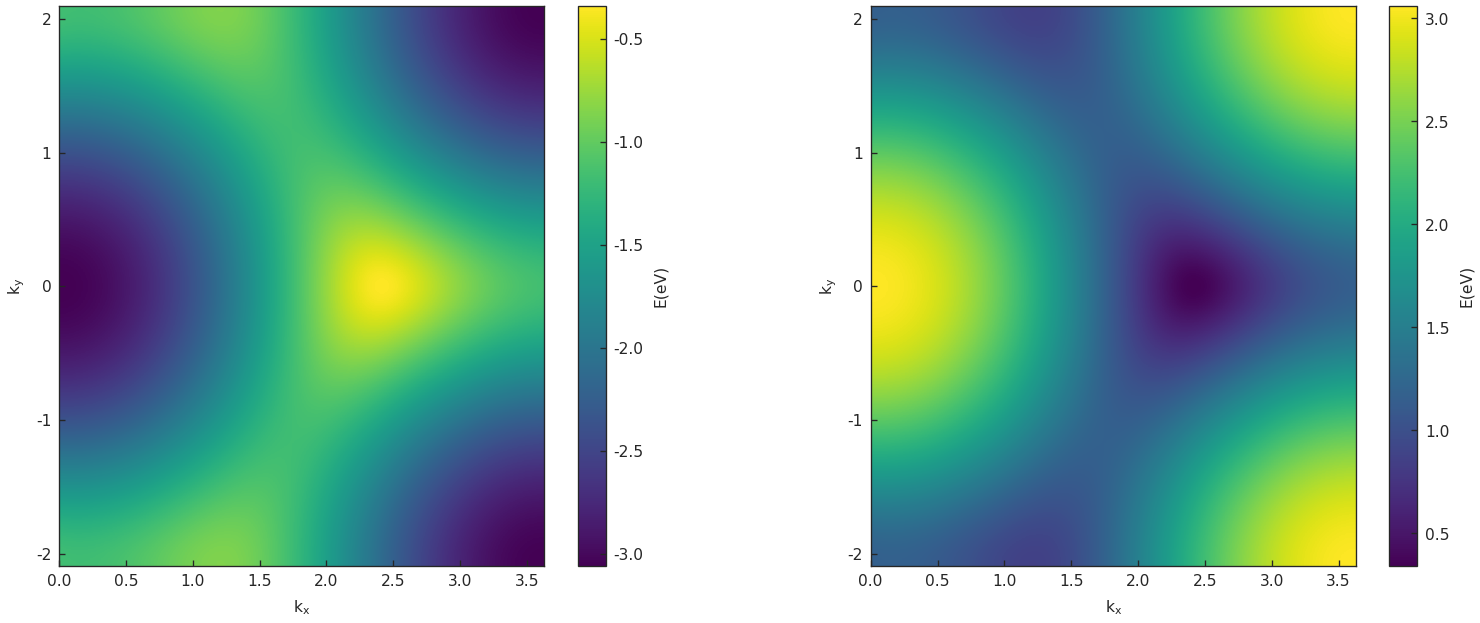

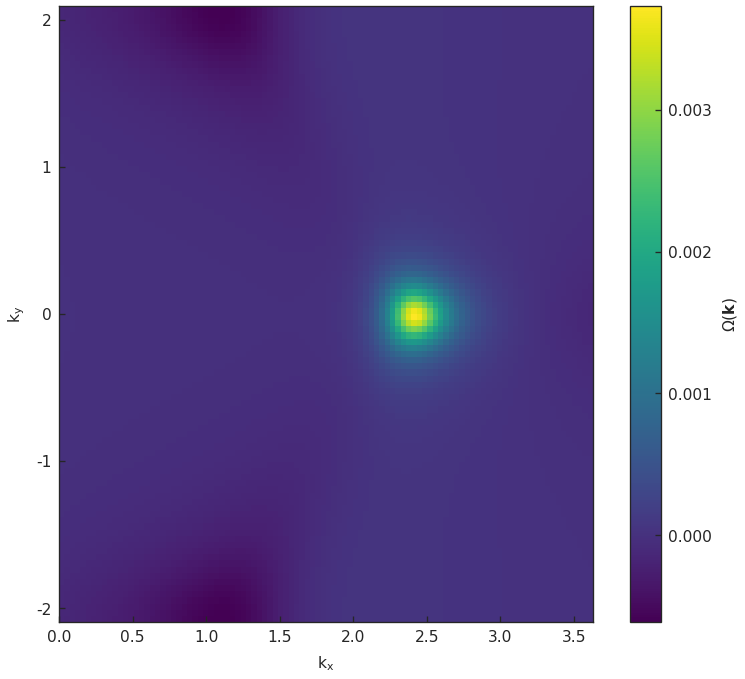

In [6]:
model = pb.Model(
    haldane(onsite=0.6),
    pb.translational_symmetry()
)
haldane().plot_brillouin_zone()
kstep = 200
solver = pb.solver.lapack(model)
# krange = [[kx,ky] for kx in np.linspace(2.5*pi/a,3.5*pi/a,kstep) for ky in np.linspace(3.5*pi/a,4.5*pi/a,kstep)]
krange = [[kx,ky] for kx in np.linspace(0,6*pi/(3*sqrt(3)),kstep) for ky in np.linspace(-2*pi/3,2*pi/3,kstep)]
bands = np.empty([len(krange),2])
eigvects = np.empty([len(krange),2,2],dtype=np.complex128)
for i in range(len(krange)):
    solver.set_wave_vector(krange[i])
    bands[i,:] = solver.eigenvalues
    eigvects[i,:,:] = solver.eigenvectors

krange = np.array(krange)
#eigvects = fixedGauge(eigvects)
from scipy.interpolate import griddata
grid_x, grid_y = np.mgrid[krange[0,0]:krange[-1,0]:200j, krange[0,-1]:krange[-1,-1]:200j]

plt.figure(figsize=(12,10))
# plt.title('Energy eigenvalues')
for i in range(bands.shape[1]):
    plt.subplot(2,2,i+1)
    grid_z0 = griddata(krange, bands[:,i], (grid_x, grid_y), method='cubic')
    plt.imshow(grid_z0.T, extent=(krange[0,0],krange[-1,0],krange[0,-1],krange[-1,-1]), origin='lower')
    plt.colorbar().set_label('E(eV)')
    plt.xlabel('$k_{x}$')
    plt.ylabel('$k_{y}$')

krangefun = krange.reshape(kstep,kstep,2)
eigvectsfun = eigvects[:,:,1].reshape(kstep,kstep,2) #Just studying the eigenvectors of one the bands

BerryHaldane = Berry(eigvectsfun,krangefun)
# print(berrCurv.shape)
ChernNumber = BerryHaldane.chern()
print(f"The Chern number of the band is: {ChernNumber}")
berrCurv_fukui = BerryHaldane.fukui_curvature()
# print(berrCurv_fukui)
BerryHaldane.curv_plot()



We can now check the bulk-boundary correspondence. For that, we construct a nanoribbon:

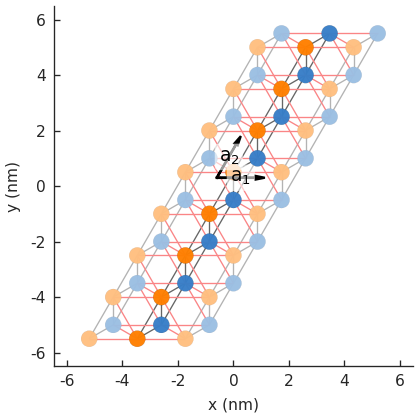

In [7]:
model = pb.Model(
    haldane(),
    pb.rectangle(12),  # nm
    pb.translational_symmetry(a1=True, a2=False)
)
model.plot()
model.lattice.plot_vectors(position=[-0.6, 0.3])


We can now check its band structure. For the topological phase, we clearly see the two edge states crossing the band gap

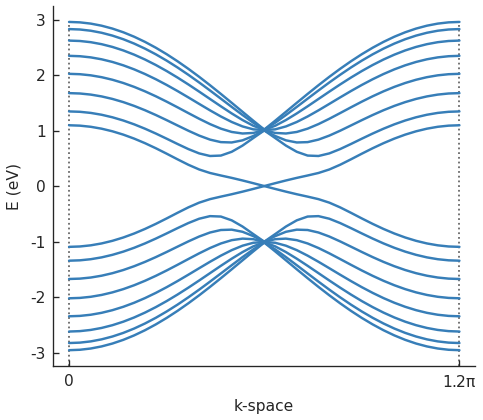

In [8]:
solver = pb.solver.lapack(model)
a = sqrt(3)  # ribbon unit cell length
bands = solver.calc_bands(0, 2*pi/a)
bands.plot()

For the non-topological phase, the edges are insulating.

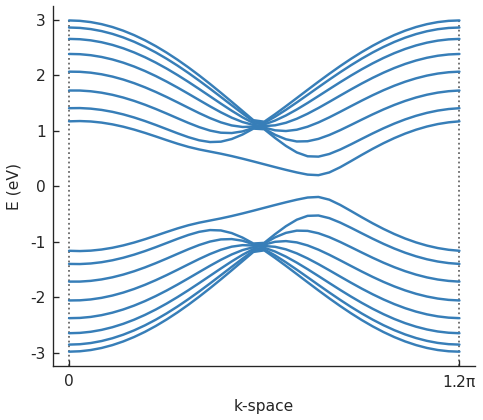

In [9]:
model = pb.Model(
    haldane(onsite=0.4),
    pb.rectangle(12),  # nm
    pb.translational_symmetry(a1=True, a2=False)
)

solver = pb.solver.lapack(model)
a = sqrt(3)  # ribbon unit cell length
bands = solver.calc_bands(0, 2*pi/a)
bands.plot()


Now let us use quantum-kite to calculate de transverse conductivity of this model

In [10]:
lattice = haldane(t2=0.2)

To help the convergence for a small lattice, we add disorder:

In [11]:
disorder = kite.Disorder(lattice)
disorder.add_disorder('A', 'Uniform', +0.0, 0.4)
disorder.add_disorder('B', 'Uniform', +0.0, 0.4)


The number of decomposition parts `[nx,ny]` in each direction of matrix. This divides the lattice into various sections, each of which is calculated in parallel:

In [12]:
nx = ny = 2

The number of unit cells in each direction:

In [13]:
lx = ly = 128

The boundary mode:

In [14]:
mode = "periodic"

Specify precision of the exported hopping and onsite data, 0 - float, 1 - double, and 2 - long double. Scaling, if None it's automatic, if present select `spectrum_range=[e_min, e_max]`.  As the model has complex hoppings, we need specify it.

In [15]:
configuration = kite.Configuration(
        divisions=[nx, ny],
        length=[lx, ly],
        boundaries=[mode, mode],
        is_complex=True,
        precision=0
    )


Especify each calculation type. In this case, the density of states and DC conductivity in `xy`. To have a defined plateau in the transverse conductivity, it is necessary to consider at least 10 random vectors. Ideally, for a small system, one needs a large number of random vectors (please refer to quantum-kite documentation). As we are running the notebooks online, we stick to 15. You can change the number of random vectors and see how it changes the conductivity.

In [16]:
calculation = kite.Calculation(configuration)

calculation = kite.Calculation(configuration)
calculation.dos(
        num_points=1000,
        num_moments=256,
        num_random=10,
        num_disorder=1
)


calculation.conductivity_dc(
        num_points=1000,
        num_moments=256,
        num_random=15,
        num_disorder=1,
        direction='xy',
        temperature=0.05
)

 Configure the *.h5 file:

In [17]:
output_file = "haldane-output.h5"
kite.config_system(lattice, configuration, calculation, filename=output_file,
                       disorder=disorder)

##############################################################################
#                        KITE | Release  1.1                                 #
#                        Kite home: quantum-kite.com                         #
#                                                                            #
#                        Copyright 2022, KITE                                #
##############################################################################

##############################################################################

SCALING:


Automatic scaling is being done. If unexpected results are produced, consider 
selecting the bounds manually. 
Estimate of the spectrum bounds with a safety factor is: 
(-3.03, 3.03 eV)


##############################################################################

BOUNDARY CONDITIONS:


Boundary conditions along the lattice vectors are set to:
 
a1: Periodic     a2: Periodic 


##################################################

execute kite inside a python script:


In [18]:
kite.execute.kitex(output_file);

<HDF5 dataset "IS_COMPLEX": shape (), type "<u4">


postprocessing the output file. Check kite documentation or the notebook that introduces kite to know the names of postprocessed files.


In [27]:
kite.execute.kitetools("haldane-output.h5 --CondDC -F -3 3 2000 -E 5000 -T 0.07");

Now we can plot the postprocessed files. In this case, `dos.dat` presents the results for density of states and `condDC.dat`, the results for the transverse conductivity.

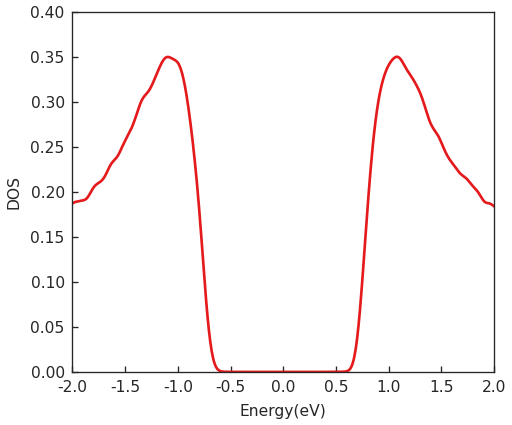

In [28]:
dos=np.loadtxt("dos.dat",dtype=float)
plt.plot(dos[:,0],dos[:,1])
plt.xlabel("Energy(eV)")
plt.ylabel("DOS")
plt.xlim(-2,2)
#plt.ylim(0,0.08)
plt.show()

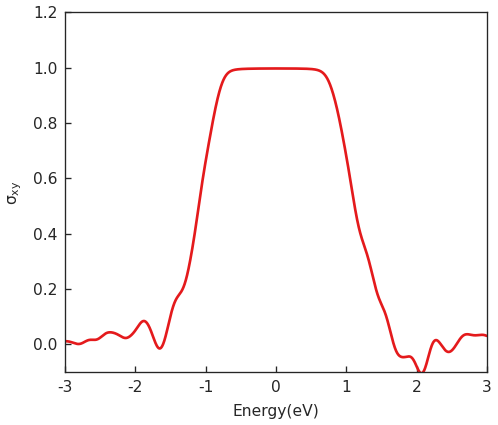

In [29]:
cond=np.loadtxt("condDC.dat",dtype=float)
plt.plot(cond[:,0],cond[:,1])
plt.xlabel("Energy(eV)")
plt.ylabel("$\sigma_{xy}$")
plt.xlim(-3,3)
plt.ylim(-0.1,1.2)
plt.show()